In [ ]:
pip install --quiet -U langchain langchain_community tiktoken langchain-nomic "nomic[local]" langchain-ollama scikit-learn langgraph tavily-python bs4

In [ ]:
!pip install langchain-nomic


In [ ]:
### LLM配置 - 使用通义千问模型
from langchain_community.chat_models import ChatTongyi

llm = ChatTongyi(
    model_name="qwen-turbo",
    temperature=0.7,
    streaming=True
)
llm_json_mode = ChatTongyi(
    model_name="qwen-turbo",
    temperature=0.7,
    streaming=True,
    format="json"
)

In [2]:
# 使用 LangSmith 追踪
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langgraph-rag-demo"

In [3]:
# 向量存储 - 文档加载、分割和向量化
# 导入必要的库用于文档处理和向量存储
from langchain.text_splitter import RecursiveCharacterTextSplitter  # 递归字符文本分割器
from langchain_community.document_loaders import WebBaseLoader  # 网页文档加载器
from langchain_community.vectorstores import SKLearnVectorStore  # 基于SKLearn的向量存储
from langchain_nomic.embeddings import NomicEmbeddings  # Nomic嵌入模型

# 定义要加载的网页URL列表，包含关于AI代理、提示工程和对抗攻击的文章
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",  # AI代理相关文章
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",  # 提示工程文章
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",  # LLM对抗攻击文章
]

# 加载文档
# 使用WebBaseLoader为每个URL加载网页内容，返回文档列表的列表
docs = [WebBaseLoader(url).load() for url in urls]
# 将嵌套的文档列表展平为单一的文档列表
docs_list = [item for sublist in docs for item in sublist]

# 分割文档
# 创建递归字符文本分割器，使用tiktoken编码器来准确计算token数量
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,  # 每个文档块的最大大小为1000个token
    chunk_overlap=200  # 相邻文档块之间重叠200个token，确保上下文连续性
)
# 将所有文档分割成较小的文档块，便于检索和处理
doc_splits = text_splitter.split_documents(docs_list)

# 添加到向量数据库
# 使用分割后的文档创建向量存储，将文档转换为向量表示
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,  # 输入分割后的文档
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local"),  # 使用Nomic嵌入模型，本地推理模式
)

# 创建检索器
# 将向量存储转换为检索器，设置返回最相关的3个文档
retriever = vectorstore.as_retriever(k=3)


USER_AGENT environment variable not set, consider setting it to identify your requests.
Embedding texts: 100%|██████████| 47/47 [01:53<00:00,  2.42s/inputs]


In [4]:
### Router - 路由模块
import json  # 用于JSON数据处理
from langchain_core.messages import HumanMessage, SystemMessage  # 导入消息类型

# 提示词定义
# 定义路由的系统指令，用于决定问题应该路由到向量存储还是网络搜索
router_instructions = """You are an expert at routing a user question to a vectorstore or web search.

The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.

Use the vectorstore for questions on these topics. For all else, and especially for current events, use web-search.

Return JSON with single key, datasource, that is 'websearch' or 'vectorstore' depending on the question."""

# 测试路由功能
# 测试1：体育赛事问题 - 应该路由到网络搜索（时事相关）
test_web_search = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]  # 系统消息包含路由指令
    + [
        HumanMessage(
            content="Who is favored to win the NFC Championship game in the 2024 season?"  # 询问2024赛季NFC冠军赛的热门球队
        )
    ]
)

# 测试2：最新模型发布问题 - 应该路由到网络搜索（时事相关）
test_web_search_2 = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]  # 系统消息包含路由指令
    + [HumanMessage(content="What are the models released today for llama3.2?")]  # 询问今天发布的llama3.2模型
)

# 测试3：代理记忆类型问题 - 应该路由到向量存储（与已有文档相关）
test_vector_store = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]  # 系统消息包含路由指令
    + [HumanMessage(content="What are the types of agent memory?")]  # 询问代理记忆的类型
)

# 打印所有测试结果，展示路由器的决策
print(
    json.loads(test_web_search.content),      # 解析第一个测试的JSON响应
    json.loads(test_web_search_2.content),   # 解析第二个测试的JSON响应
    json.loads(test_vector_store.content),   # 解析第三个测试的JSON响应
)


{'datasource': 'websearch'} {'datasource': 'websearch'} {'datasource': 'vectorstore'}


In [5]:
### Retrieval Grader - 检索评分器模块

# 文档评分器指令
# 定义文档评分器的系统指令，用于评估检索到的文档与用户问题的相关性
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""

# 评分器提示词模板
# 定义具体的评分提示词，包含文档内容和用户问题
doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}. 

This carefully and objectively assess whether the document contains at least some information that is relevant to the question.

Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question."""

# 测试检索评分器功能
question = "What is Chain of thought prompting?"  # 测试问题：什么是思维链提示
docs = retriever.invoke(question)  # 使用检索器根据问题检索相关文档
doc_txt = docs[1].page_content  # 获取第二个文档的页面内容用于测试
# 格式化评分提示词，将实际的文档内容和问题填入模板
doc_grader_prompt_formatted = doc_grader_prompt.format(
    document=doc_txt, question=question
)
# 调用LLM进行文档相关性评分
result = llm_json_mode.invoke(
    [SystemMessage(content=doc_grader_instructions)]  # 系统消息包含评分指令
    + [HumanMessage(content=doc_grader_prompt_formatted)]  # 用户消息包含格式化的评分提示
)
# 解析并返回JSON格式的评分结果
json.loads(result.content)


Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 21.43inputs/s]


{'binary_score': 'yes'}

In [6]:
### Generate - 生成器模块

# 提示词模板
# 定义RAG（检索增强生成）的提示词模板，用于基于检索到的上下文回答问题
rag_prompt = """You are an assistant for question-answering tasks. 

Here is the context to use to answer the question:

{context} 

Think carefully about the above context. 

Now, review the user question:

{question}

Provide an answer to this questions using only the above context. 

Use three sentences maximum and keep the answer concise.

Answer:"""


# 后处理函数
# 定义文档格式化函数，将多个文档合并为单一的上下文字符串
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)  # 用双换行符连接所有文档的页面内容


# 测试生成功能
docs = retriever.invoke(question)  # 使用检索器根据问题检索相关文档
docs_txt = format_docs(docs)  # 将检索到的文档格式化为文本字符串
# 格式化RAG提示词，将上下文和问题填入模板
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
# 调用LLM生成基于上下文的答案
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
# 打印生成的答案内容
print(generation.content)


Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 24.79inputs/s]


Chain of Thought (CoT) prompting generates a sequence of short sentences to describe reasoning steps, leading to a final answer. It is particularly effective for complex reasoning tasks and can be implemented through few-shot examples or zero-shot instructions like "Let's think step by step." CoT helps improve accuracy by breaking down problems into logical steps.


In [7]:
### Hallucination Grader - 幻觉评分器模块

# 幻觉评分器指令
# 定义幻觉评分器的系统指令，用于检查生成的答案是否基于提供的事实，避免产生虚假信息
hallucination_grader_instructions = """

You are a teacher grading a quiz. 

You will be given FACTS and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is grounded in the FACTS. 

(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# 评分器提示词模板
# 定义具体的幻觉检测提示词，包含事实文档和学生答案的占位符
hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}. 

Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER is grounded in the FACTS. And a key, explanation, that contains an explanation of the score."""

# 使用上面的文档和生成内容进行测试
# 格式化幻觉检测提示词，将实际的文档内容和生成的答案填入模板
hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
    documents=docs_txt, generation=generation.content  # docs_txt是格式化的文档，generation.content是LLM生成的答案
)
# 调用LLM进行幻觉检测评分
result = llm_json_mode.invoke(
    [SystemMessage(content=hallucination_grader_instructions)]  # 系统消息包含幻觉检测指令
    + [HumanMessage(content=hallucination_grader_prompt_formatted)]  # 用户消息包含格式化的检测提示
)
# 解析并返回JSON格式的评分结果，包含二元评分和解释
json.loads(result.content)


{'binary_score': 'yes',
 'explanation': "The student's answer is grounded in the facts provided. The description of Chain-of-Thought (CoT) prompting as generating a sequence of short sentences to describe reasoning steps, leading to a final answer, matches the definition given in the facts. The statement that it is particularly effective for complex reasoning tasks aligns with the fact that 'the benefit of CoT is more pronounced for complicated reasoning tasks.' The mention of few-shot examples and zero-shot instructions like 'Let's think step by step' corresponds to the facts describing two main types of CoT prompting: Few-shot CoT and Zero-shot CoT. Finally, the claim that CoT helps improve accuracy by breaking down problems into logical steps is consistent with the overall purpose of CoT as described in the facts."}

In [8]:
### Answer Grader - 答案评分器模块

# 答案评分器指令
# 定义答案评分器的系统指令，用于评估学生答案是否有效回答了给定问题
answer_grader_instructions = """You are a teacher grading a quiz. 

You will be given a QUESTION and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) The STUDENT ANSWER helps to answer the QUESTION

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# 评分器提示词模板
# 定义具体的答案评分提示词，包含问题和学生答案的占位符
answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}. 

Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER meets the criteria. And a key, explanation, that contains an explanation of the score."""

# 测试数据
question = "What are the vision models released today as part of Llama 3.2?"  # 测试问题：今天发布的Llama 3.2视觉模型有哪些？
# 测试答案：包含Llama 3.2视觉模型的详细信息
answer = "The Llama 3.2 models released today include two vision models: Llama 3.2 11B Vision Instruct and Llama 3.2 90B Vision Instruct, which are available on Azure AI Model Catalog via managed compute. These models are part of Meta's first foray into multimodal AI and rival closed models like Anthropic's Claude 3 Haiku and OpenAI's GPT-4o mini in visual reasoning. They replace the older text-only Llama 3.1 models."

# 使用上面的问题和答案进行测试
# 格式化答案评分提示词，将实际的问题和答案填入模板
answer_grader_prompt_formatted = answer_grader_prompt.format(
    question=question, generation=answer  # question是测试问题，answer是要评分的答案
)
# 调用LLM进行答案质量评分
result = llm_json_mode.invoke(
    [SystemMessage(content=answer_grader_instructions)]  # 系统消息包含答案评分指令
    + [HumanMessage(content=answer_grader_prompt_formatted)]  # 用户消息包含格式化的评分提示
)
# 解析并返回JSON格式的评分结果，包含二元评分和解释
json.loads(result.content)


{'binary_score': 'yes',
 'explanation': "The student's answer directly addresses the question by listing the vision models released as part of Llama 3.2, specifically naming 'Llama 3.2 11B Vision Instruct' and 'Llama 3.2 90B Vision Instruct.' This information is exactly what the question asks for. While the answer includes additional context about the models being part of Meta's first foray into multimodal AI and their competition with other models, this extra information does not detract from the accuracy or relevance of the answer. Therefore, the student's response meets all the criteria for a 'yes' score."}

In [16]:
# 搜索

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_804\2725807216.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3)


In [ ]:
# 状态定义
# 图的 `state` (状态) 模式包含我们想要
# 传递给我们图中每个节点的键
# （可选）在我们图的每个节点中修改

# 导入必要的类型定义库
import operator  # 操作符模块，用于定义累加操作
from typing_extensions import TypedDict  # 类型化字典，提供类型提示
from typing import List, Annotated  # 列表类型和注解类型


class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    图状态是一个字典，包含我们想要传播到图中每个节点并在其中修改的信息。
    """

    question: str  # 用户问题 - 存储用户输入的查询问题
    generation: str  # LLM生成内容 - 存储大语言模型生成的回答
    web_search: str  # 网络搜索决策 - 二元决策，决定是否运行网络搜索
    max_retries: int  # 最大重试次数 - 答案生成的最大重试次数限制
    answers: int  # 答案数量 - 已生成的答案数量计数
    loop_step: Annotated[int, operator.add]  # 循环步骤 - 使用累加操作符跟踪循环迭代次数
    documents: List[str]  # 文档列表 - 存储检索到的相关文档列表


In [ ]:
# 节点定义
# 我们图中的每个节点都只是一个函数，它会
# (1) 将 `state` (状态) 作为输入
# (2) 修改 `state` (状态)
# (3) 将修改后的 `state` (状态) 写入状态模式 (字典) 中

# 导入必要的模块
from langchain.schema import Document  # 文档类，用于创建文档对象
from langgraph.graph import END  # 图的结束节点


### Nodes - 节点函数定义
def retrieve(state):
    """
    从向量存储中检索文档
    Retrieve documents from vectorstore

    Args:
        state (dict): 当前图状态 The current graph state

    Returns:
        state (dict): 添加了新键documents的状态，包含检索到的文档 New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")  # 打印当前执行的步骤
    question = state["question"]  # 从状态中获取用户问题

    # 将检索到的文档写入状态的documents键中
    documents = retriever.invoke(question)  # 使用检索器根据问题检索相关文档
    return {"documents": documents}  # 返回包含文档的状态更新


def generate(state):
    """
    使用RAG在检索到的文档上生成答案
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): 当前图状态 The current graph state

    Returns:
        state (dict): 添加了新键generation的状态，包含LLM生成内容 New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")  # 打印当前执行的步骤
    question = state["question"]  # 从状态中获取用户问题
    documents = state["documents"]  # 从状态中获取检索到的文档
    loop_step = state.get("loop_step", 0)  # 获取当前循环步骤，默认为0

    # RAG生成过程
    docs_txt = format_docs(documents)  # 格式化文档为文本字符串
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)  # 格式化RAG提示词
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])  # 调用LLM生成答案
    return {"generation": generation, "loop_step": loop_step + 1}  # 返回生成内容和更新的循环步骤


def grade_documents(state):
    """
    判断检索到的文档是否与问题相关
    如果任何文档不相关，我们将设置标志来运行网络搜索
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): 当前图状态 The current graph state

    Returns:
        state (dict): 过滤掉不相关文档并更新web_search状态 Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")  # 打印当前执行的步骤
    question = state["question"]  # 从状态中获取用户问题
    documents = state["documents"]  # 从状态中获取检索到的文档

    # 对每个文档进行评分
    filtered_docs = []  # 初始化过滤后的文档列表
    web_search = "No"  # 初始化网络搜索标志为"No"
    for d in documents:  # 遍历每个文档
        # 格式化文档评分提示词
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document=d.page_content, question=question
        )
        # 调用LLM对文档相关性进行评分
        result = llm_json_mode.invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]  # 解析评分结果
        # 文档相关
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")  # 打印文档相关信息
            filtered_docs.append(d)  # 将相关文档添加到过滤列表
        # 文档不相关
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")  # 打印文档不相关信息
            # 我们不将该文档包含在filtered_docs中
            # 我们设置标志表示要运行网络搜索
            web_search = "Yes"  # 设置网络搜索标志为"Yes"
            continue  # 继续处理下一个文档
    return {"documents": filtered_docs, "web_search": web_search}  # 返回过滤后的文档和搜索标志


def web_search(state):
    """
    基于问题进行网络搜索
    Web search based based on the question

    Args:
        state (dict): 当前图状态 The current graph state

    Returns:
        state (dict): 将网络搜索结果附加到文档中 Appended web results to documents
    """

    print("---WEB SEARCH---")  # 打印当前执行的步骤
    question = state["question"]  # 从状态中获取用户问题
    documents = state.get("documents", [])  # 从状态中获取现有文档，默认为空列表

    # 网络搜索
    docs = web_search_tool.invoke({"query": question})  # 使用网络搜索工具搜索问题
    web_results = "\n".join([d["content"] for d in docs])  # 将搜索结果合并为文本
    web_results = Document(page_content=web_results)  # 创建文档对象
    documents.append(web_results)  # 将网络搜索结果添加到文档列表
    return {"documents": documents}  # 返回更新后的文档列表


### Edges - 边函数定义（用于节点间路由）


def route_question(state):
    """
    将问题路由到网络搜索或RAG
    Route question to web search or RAG

    Args:
        state (dict): 当前图状态 The current graph state

    Returns:
        str: 要调用的下一个节点 Next node to call
    """

    print("---ROUTE QUESTION---")  # 打印当前执行的步骤
    # 调用路由器LLM决定使用哪种数据源
    route_question = llm_json_mode.invoke(
        [SystemMessage(content=router_instructions)]
        + [HumanMessage(content=state["question"])]
    )
    source = json.loads(route_question.content)["datasource"]  # 解析数据源决策
    if source == "websearch":
        print("---ROUTE QUESTION TO WEB SEARCH---")  # 路由到网络搜索
        return "websearch"
    elif source == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")  # 路由到RAG（向量存储）
        return "vectorstore"


def decide_to_generate(state):
    """
    决定是生成答案还是添加网络搜索
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): 当前图状态 The current graph state

    Returns:
        str: 要调用的下一个节点的二元决策 Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")  # 打印当前执行的步骤
    question = state["question"]  # 从状态中获取用户问题
    web_search = state["web_search"]  # 从状态中获取网络搜索标志
    filtered_documents = state["documents"]  # 从状态中获取过滤后的文档

    if web_search == "Yes":
        # 所有文档都已被过滤检查相关性
        # 我们将重新生成一个新查询
        print(
            "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"  # 返回网络搜索节点
    else:
        # 我们有相关文档，所以生成答案
        print("---DECISION: GENERATE---")
        return "generate"  # 返回生成节点


def grade_generation_v_documents_and_question(state):
    """
    判断生成内容是否基于文档并回答了问题
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): 当前图状态 The current graph state

    Returns:
        str: 要调用的下一个节点的决策 Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")  # 打印当前执行的步骤
    question = state["question"]  # 从状态中获取用户问题
    documents = state["documents"]  # 从状态中获取文档
    generation = state["generation"]  # 从状态中获取生成内容
    max_retries = state.get("max_retries", 3)  # 获取最大重试次数，默认为3

    # 格式化幻觉检测提示词
    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
        documents=format_docs(documents), generation=generation.content
    )
    # 调用LLM进行幻觉检测
    result = llm_json_mode.invoke(
        [SystemMessage(content=hallucination_grader_instructions)]
        + [HumanMessage(content=hallucination_grader_prompt_formatted)]
    )
    grade = json.loads(result.content)["binary_score"]  # 解析幻觉检测结果

    # 检查幻觉
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")  # 生成内容基于文档
        # 检查问题回答质量
        print("---GRADE GENERATION vs QUESTION---")
        # 使用上面的问题和生成内容进行测试
        answer_grader_prompt_formatted = answer_grader_prompt.format(
            question=question, generation=generation.content
        )
        # 调用LLM进行答案质量评分
        result = llm_json_mode.invoke(
            [SystemMessage(content=answer_grader_instructions)]
            + [HumanMessage(content=answer_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]  # 解析答案质量评分
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")  # 生成内容回答了问题
            return "useful"  # 返回有用标志
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")  # 生成内容未回答问题
            return "not useful"  # 返回无用标志
        else:
            print("---DECISION: MAX RETRIES REACHED---")  # 达到最大重试次数
            return "max retries"  # 返回最大重试标志
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")  # 生成内容未基于文档，重试
        return "not supported"  # 返回不支持标志
    else:
        print("---DECISION: MAX RETRIES REACHED---")  # 达到最大重试次数
        return "max retries"  # 返回最大重试标志


In [ ]:
# 每个边在图中的节点之间进行路由。
# 边函数负责决定工作流的下一步执行哪个节点

# 导入必要的模块
from langchain.schema import Document  # 文档类，用于创建文档对象
from langgraph.graph import END  # 图的结束节点


### Nodes - 节点函数定义
def retrieve(state):
    """
    从向量存储中检索文档
    Retrieve documents from vectorstore

    Args:
        state (dict): 当前图状态 The current graph state

    Returns:
        state (dict): 添加了新键documents的状态，包含检索到的文档 New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")  # 打印检索步骤标识
    question = state["question"]  # 从状态中提取用户问题

    # 将检索到的文档写入状态的documents键中
    documents = retriever.invoke(question)  # 调用检索器获取相关文档
    return {"documents": documents}  # 返回包含检索文档的状态更新


def generate(state):
    """
    使用RAG在检索到的文档上生成答案
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): 当前图状态 The current graph state

    Returns:
        state (dict): 添加了新键generation的状态，包含LLM生成内容 New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")  # 打印生成步骤标识
    question = state["question"]  # 从状态中获取用户问题
    documents = state["documents"]  # 从状态中获取检索到的文档
    loop_step = state.get("loop_step", 0)  # 获取当前循环步数，默认为0

    # RAG生成过程
    docs_txt = format_docs(documents)  # 将文档列表格式化为文本字符串
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)  # 使用上下文和问题格式化提示词
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])  # 调用LLM生成回答
    return {"generation": generation, "loop_step": loop_step + 1}  # 返回生成结果和递增的循环步数


def grade_documents(state):
    """
    判断检索到的文档是否与问题相关
    如果任何文档不相关，我们将设置标志来运行网络搜索
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): 当前图状态 The current graph state

    Returns:
        state (dict): 过滤掉不相关文档并更新web_search状态 Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")  # 打印文档相关性检查标识
    question = state["question"]  # 从状态中获取用户问题
    documents = state["documents"]  # 从状态中获取检索到的文档

    # 对每个文档进行评分
    filtered_docs = []  # 初始化过滤后的文档列表
    web_search = "No"  # 初始化网络搜索标志为否
    for d in documents:  # 遍历每个检索到的文档
        # 格式化文档评分提示词
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document=d.page_content, question=question
        )
        # 调用LLM对文档相关性进行评分
        result = llm_json_mode.invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]  # 解析评分结果
        # 文档相关
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")  # 打印文档相关信息
            filtered_docs.append(d)  # 将相关文档添加到过滤列表
        # 文档不相关
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")  # 打印文档不相关信息
            # 我们不将该文档包含在filtered_docs中
            # 我们设置标志表示要运行网络搜索
            web_search = "Yes"  # 设置网络搜索标志为是
            continue  # 继续处理下一个文档
    return {"documents": filtered_docs, "web_search": web_search}  # 返回过滤后的文档和搜索标志


def web_search(state):
    """
    基于问题进行网络搜索
    Web search based based on the question

    Args:
        state (dict): 当前图状态 The current graph state

    Returns:
        state (dict): 将网络搜索结果附加到文档中 Appended web results to documents
    """

    print("---WEB SEARCH---")  # 打印网络搜索步骤标识
    question = state["question"]  # 从状态中获取用户问题
    documents = state.get("documents", [])  # 从状态中获取现有文档，默认为空列表

    # 网络搜索
    docs = web_search_tool.invoke({"query": question})  # 使用网络搜索工具执行搜索
    web_results = "\n".join([d["content"] for d in docs])  # 将搜索结果内容合并为字符串
    web_results = Document(page_content=web_results)  # 创建包含搜索结果的文档对象
    documents.append(web_results)  # 将网络搜索结果添加到现有文档列表
    return {"documents": documents}  # 返回更新后的文档列表


### Edges - 边函数定义（控制节点间的路由逻辑）


def route_question(state):
    """
    将问题路由到网络搜索或RAG
    Route question to web search or RAG

    Args:
        state (dict): 当前图状态 The current graph state

    Returns:
        str: 要调用的下一个节点名称 Next node to call
    """

    print("---ROUTE QUESTION---")  # 打印问题路由步骤标识
    # 使用路由器LLM决定数据源
    route_question = llm_json_mode.invoke(
        [SystemMessage(content=router_instructions)]
        + [HumanMessage(content=state["question"])]
    )
    source = json.loads(route_question.content)["datasource"]  # 解析路由决策结果
    if source == "websearch":
        print("---ROUTE QUESTION TO WEB SEARCH---")  # 路由到网络搜索
        return "websearch"  # 返回网络搜索节点名
    elif source == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")  # 路由到RAG检索
        return "vectorstore"  # 返回向量存储节点名


def decide_to_generate(state):
    """
    决定是生成答案还是添加网络搜索
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): 当前图状态 The current graph state

    Returns:
        str: 要调用的下一个节点的二元决策 Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")  # 打印文档评估步骤标识
    question = state["question"]  # 从状态中获取用户问题
    web_search = state["web_search"]  # 从状态中获取网络搜索标志
    filtered_documents = state["documents"]  # 从状态中获取过滤后的文档

    if web_search == "Yes":
        # 所有文档都已被过滤检查相关性
        # 我们将重新生成一个新查询
        print(
            "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"  # 返回网络搜索节点
    else:
        # 我们有相关文档，所以生成答案
        print("---DECISION: GENERATE---")  # 决定生成答案
        return "generate"  # 返回生成节点


def grade_generation_v_documents_and_question(state):
    """
    判断生成内容是否基于文档并回答了问题
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): 当前图状态 The current graph state

    Returns:
        str: 要调用的下一个节点的决策 Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")  # 打印幻觉检查步骤标识
    question = state["question"]  # 从状态中获取用户问题
    documents = state["documents"]  # 从状态中获取文档
    generation = state["generation"]  # 从状态中获取生成内容
    max_retries = state.get("max_retries", 3)  # 获取最大重试次数，默认为3

    # 格式化幻觉检测提示词
    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
        documents=format_docs(documents), generation=generation.content
    )
    # 调用LLM进行幻觉检测
    result = llm_json_mode.invoke(
        [SystemMessage(content=hallucination_grader_instructions)]
        + [HumanMessage(content=hallucination_grader_prompt_formatted)]
    )
    grade = json.loads(result.content)["binary_score"]  # 解析幻觉检测结果

    # 检查幻觉
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")  # 生成内容基于文档
        # 检查问题回答质量
        print("---GRADE GENERATION vs QUESTION---")  # 评估生成内容与问题的匹配度
        # 使用上面的问题和生成内容进行测试
        answer_grader_prompt_formatted = answer_grader_prompt.format(
            question=question, generation=generation.content
        )
        # 调用LLM进行答案质量评分
        result = llm_json_mode.invoke(
            [SystemMessage(content=answer_grader_instructions)]
            + [HumanMessage(content=answer_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]  # 解析答案质量评分
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")  # 生成内容回答了问题
            return "useful"  # 返回有用标志，结束流程
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")  # 生成内容未回答问题
            return "not useful"  # 返回无用标志，需要网络搜索
        else:
            print("---DECISION: MAX RETRIES REACHED---")  # 达到最大重试次数
            return "max retries"  # 返回最大重试标志，结束流程
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")  # 生成内容未基于文档，重试
        return "not supported"  # 返回不支持标志，重新生成
    else:
        print("---DECISION: MAX RETRIES REACHED---")  # 达到最大重试次数
        return "max retries"  # 返回最大重试标志，结束流程


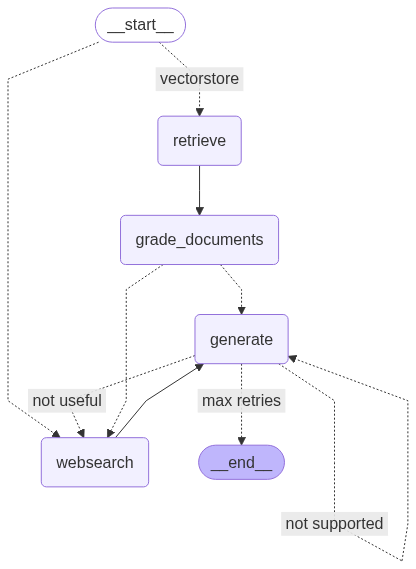

In [20]:
# 控制流 - 构建和配置LangGraph工作流

# 导入必要的模块
from langgraph.graph import StateGraph  # 状态图类，用于构建工作流图
from IPython.display import Image, display  # 用于显示图像的模块

# 创建状态图工作流，使用之前定义的GraphState作为状态模式
workflow = StateGraph(GraphState)

# 定义节点 - 将函数添加为图中的节点
workflow.add_node("websearch", web_search)  # 添加网络搜索节点
workflow.add_node("retrieve", retrieve)  # 添加文档检索节点
workflow.add_node("grade_documents", grade_documents)  # 添加文档评分节点
workflow.add_node("generate", generate)  # 添加答案生成节点

# 构建图结构
# 设置条件入口点 - 根据问题类型决定起始节点
workflow.set_conditional_entry_point(
    route_question,  # 路由函数，决定使用哪个数据源
    {
        "websearch": "websearch",    # 如果路由结果是"websearch"，跳转到网络搜索节点
        "vectorstore": "retrieve",   # 如果路由结果是"vectorstore"，跳转到检索节点
    },
)

# 添加固定边 - 定义节点间的直接连接
workflow.add_edge("websearch", "generate")  # 网络搜索后直接跳转到生成节点
workflow.add_edge("retrieve", "grade_documents")  # 检索后跳转到文档评分节点

# 添加条件边 - 根据函数返回值决定下一个节点
workflow.add_conditional_edges(
    "grade_documents",  # 从文档评分节点出发
    decide_to_generate,  # 决策函数，判断是否可以生成答案
    {
        "websearch": "websearch",  # 如果需要网络搜索，跳转到网络搜索节点
        "generate": "generate",    # 如果可以生成答案，跳转到生成节点
    },
)

# 添加生成节点的条件边 - 评估生成质量并决定下一步
workflow.add_conditional_edges(
    "generate",  # 从生成节点出发
    grade_generation_v_documents_and_question,  # 评估函数，检查生成质量
    {
        "not supported": "generate",    # 如果生成内容不基于文档，重新生成
        "useful": END,                  # 如果生成内容有用，结束流程
        "not useful": "websearch",      # 如果生成内容无用，进行网络搜索
        "max retries": END,             # 如果达到最大重试次数，结束流程
    },
)

# 编译工作流图
graph = workflow.compile()  # 将工作流编译为可执行的图

# 显示工作流图的可视化表示
display(Image(graph.get_graph().draw_mermaid_png()))  # 生成并显示Mermaid格式的流程图


In [21]:
inputs = {"question": "What are the types of agent memory?", "max_retries": 3}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
{'question': 'What are the types of agent memory?', 'max_retries': 3, 'loop_step': 0}
---RETRIEVE---


Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 22.62inputs/s]

{'question': 'What are the types of agent memory?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'id': '6263b6ea-5182-4860-9cee-b31e5e5a1e61', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-c

---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
{'question': 'What are the types of agent memory?', 'web_search': 'Yes', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'id': '6263b6ea-5182-4860-9cee-b31e5e5a1e61', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent

In [22]:
# Test on current events
inputs = {
    "question": "What are the models released today for llama3.2?",
    "max_retries": 3,
}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
{'question': 'What are the models released today for llama3.2?', 'max_retries': 3, 'loop_step': 0}
---WEB SEARCH---
{'question': 'What are the models released today for llama3.2?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={}, page_content='Meta has released compact versions of its lightweight Llama 3.2 1B and 3B models that are small enough to run effectively on mobile devices.\n\nThe Facebook owner, in an announcement yesterday (24 October), said that these new “quantised” models are 56pc smaller and use 41pc less memory when compared to the original 3.2 models released last month. [...] Silicon Republic\n\n# Meta releases compact versions of Llama 3.2 AI models\n\nby Suhasini Srinivasaragavan\n\n25 Oct 2024\n\nA colourful illustration of a mobile phone with a big AIG symbol and speech bubbles to symbolise using AI models on your phone.\n\nImage: © ImageFlow/Stock.adobe.com\n\nThe new quantised models are